In [1]:
import os
workdir = "/Users/jingwenren/Documents/CSCI599/Assignment1/FinalProject/datasets/Project"        
os.chdir(workdir) # change the current work directory to workdir

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

In [2]:
def loaddata(path, seed=9527):
    """
    Usage: there should be ./breast/ and ./prostate/ under the path
    """
    
    np.random.seed(seed=seed)
    
    def image2tensor(tumor, cnv):
        train1, train2, train3, testset1, testset2, testset3 = [], [], [], [], [], [] # creat lists
        train = [train1, train2, train3] # 3 channels  "dapi" "ck" "cd45"
        test = [testset1, testset2, testset3]

        rawfnames = !ls ./$tumor/$cnv/*jpg #!: magic command
        rawfnames = np.array(np.sort(rawfnames), dtype=object)
        
        # randomly distribute data to train set and test set in 5:1 ratio
        randomIndices = np.random.permutation(rawfnames.shape[0]//3) 
        for i, rawf in enumerate(rawfnames):
            im = cv2.imread(rawf, 0)
            #print("im.shape",im.shape)
            channel = i % 3
            if (randomIndices[i//3]) % 6 == 0:
                test[channel].append(im)
            else:
                train[channel].append(im)
        print(np.array(train).shape)
        return np.array(train).transpose([1,2,3,0]), np.array(test).transpose([1,2,3,0])
    
    tumors = ["breast", "prostate"]
    cnvs = ["altered", "flat"]
    
    trainset,  testset = {"breast" : {}, "prostate" : {}}, {"breast" : {}, "prostate" : {}}
    data = {"trainset" : trainset , "testset" : testset} # create dictionary
    
    for tumor in tumors:
        for i, cnv in enumerate(cnvs):
            if i == 0:
                trainset[tumor]["pos"], testset[tumor]["pos"] = image2tensor(tumor, cnv)
            if i == 1:
                trainset[tumor]["neg"], testset[tumor]["neg"] = image2tensor(tumor, cnv)
                
    return data

(3, 484, 225, 225)
(3, 455, 225, 225)
(3, 323, 225, 225)
(3, 285, 225, 225)
trainset breast pos (484, 225, 225, 3)
trainset breast neg (455, 225, 225, 3)
trainset prostate pos (323, 225, 225, 3)
trainset prostate neg (285, 225, 225, 3)
testset breast pos (97, 225, 225, 3)
testset breast neg (92, 225, 225, 3)
testset prostate pos (65, 225, 225, 3)
testset prostate neg (58, 225, 225, 3)


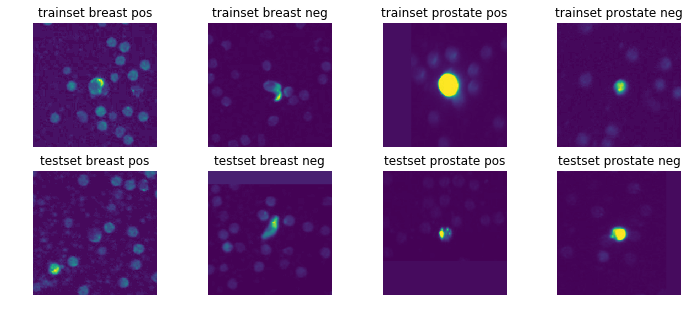

In [17]:
data = loaddata(workdir)

fig, axes = plt.subplots(2,4, figsize=(12,5))
i, j = 0, 0

for subset, d1 in data.items():
    for tumor, d2 in d1.items():
        for cnv, imgs in d2.items():
            print("{} {} {} {}".format(subset, tumor, cnv, imgs.shape))
            axes[i,j%4].imshow(data[subset][tumor][cnv][0][:,:,1])
            axes[i,j%4].set_title("{} {} {}".format(subset, tumor, cnv))
            axes[i,j%4].axis('off')
            j += 1
    i += 1

plt.show()
plt.close()



In [ ]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os


batch_size = 32
num_classes = 2
epochs = 15
data_augmentation = True

# Get the x_train y_train for one tumor type "breast"
tumor = "breast"
x_train1 = data["trainset"][tumor]["pos"]
x_train2 = data["trainset"][tumor]["neg"]
s1 = (x_train1.shape[0],1)
s2 = (x_train2.shape[0],1)
y_train1 = np.ones(s1, dtype=int)
y_train2 = np.zeros(s2, dtype=int)
x_train = np.concatenate((x_train1, x_train2), axis=0)
y_train = np.concatenate((y_train1, y_train2), axis=0)
y_train = keras.utils.to_categorical(y_train, num_classes)
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

# Get the x_test y_test from one tumor type
x_test1 = data["testset"][tumor]["pos"]
x_test2 = data["testset"][tumor]["neg"]
s1 = (x_test1.shape[0],1)
s2 = (x_test2.shape[0],1)
y_test1 = np.ones(s1, dtype=int)
y_test2 = np.zeros(s2, dtype=int)
x_test = np.concatenate((x_test1, x_test2), axis=0)
y_test = np.concatenate((y_test1, y_test2), axis=0)
num_classes = 2
y_test = keras.utils.to_categorical(y_test, num_classes)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


In [ ]:
# USe the naive CNN with zero center as "preprocessing" and data augmentation
# This model achieves 0.75 accuracy on test data

# Define the model
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', strides = 1, input_shape=x_train.shape[1:])) # (225, 225, 3)
model.add(keras.layers.BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(keras.layers.BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(keras.layers.BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(keras.layers.BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])



In [ ]:
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    # use zero center and flip
    datagen = ImageDataGenerator(
        featurewise_center=True,# set input mean to 0 over the dataset
        rotation_range=90, 
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True) 
    
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)


    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()